<a href="https://colab.research.google.com/github/Hitika-Jain/ParkInsight/blob/main/lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
dataset_path = "/content/drive/MyDrive/parkinson's audio dataset"

In [2]:
!pip install librosa soundfile numpy pandas tensorflow tqdm

In [2]:
import os
import librosa
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [3]:
def extract_mfcc(file_path, max_pad_len=100):
    try:
        y, sr = librosa.load(file_path, sr=22050)  # Load audio
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)  # Extract 13 MFCCs

        # Pad or truncate to a fixed length
        if mfcc.shape[1] < max_pad_len:
            pad_width = max_pad_len - mfcc.shape[1]
            mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')
        else:
            mfcc = mfcc[:, :max_pad_len]

        return mfcc.T  # Shape: (timesteps, features)
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

In [4]:
import os
import librosa
import numpy as np
from tqdm import tqdm

data = []
labels = []

# Define the dataset path
dataset_path = "/content/drive/MyDrive/parkinson's audio dataset"

# Define category paths and labels
categories = {
    "15 Young Healthy Control": 0,
    "22 Elderly Healthy Control": 0,
    "28 People with Parkinson's disease": 1
}

# Function to extract MFCC features
def extract_mfcc(file_path, max_pad_len=100):
    try:
        y, sr = librosa.load(file_path, sr=22050)  # Load audio
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)  # Extract 13 MFCCs

        # Pad or truncate to a fixed length
        if mfcc.shape[1] < max_pad_len:
            pad_width = max_pad_len - mfcc.shape[1]
            mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')
        else:
            mfcc = mfcc[:, :max_pad_len]

        return mfcc.T  # Shape: (timesteps, features)
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

# Process each category
for category, label in categories.items():
    category_path = os.path.join(dataset_path, category)

    if not os.path.isdir(category_path):
        continue  # Skip files like "FILE CODES.xlsx"

    if category == "28 People with Parkinson's disease":  # Handling nested structure
        for group_folder in tqdm(os.listdir(category_path), desc="Processing Parkinson's patients"):
            group_path = os.path.join(category_path, group_folder)

            if not os.path.isdir(group_path):
                continue  # Skip any non-directory files

            for patient_folder in os.listdir(group_path):
                patient_path = os.path.join(group_path, patient_folder)

                if not os.path.isdir(patient_path):
                    continue  # Skip any non-directory files

                for file in os.listdir(patient_path):
                    if file.endswith(".wav"):
                        file_path = os.path.join(patient_path, file)
                        mfcc_features = extract_mfcc(file_path)

                        if mfcc_features is not None:
                            data.append(mfcc_features)
                            labels.append(label)

    else:  # Normal structure (Healthy Controls)
        for patient_folder in tqdm(os.listdir(category_path), desc=f"Processing {category}"):
            patient_path = os.path.join(category_path, patient_folder)

            if not os.path.isdir(patient_path):
                continue  # Skip any non-directory files

            for file in os.listdir(patient_path):
                if file.endswith(".wav"):
                    file_path = os.path.join(patient_path, file)
                    mfcc_features = extract_mfcc(file_path)

                    if mfcc_features is not None:
                        data.append(mfcc_features)
                        labels.append(label)

# Convert to NumPy arrays
X = np.array(data)
y = np.array(labels)

print(f"Extracted {X.shape[0]} samples with shape {X.shape[1:]}")  # (samples, timesteps, features)

Processing Parkinson's patients: 100%|██████████| 6/6 [02:38<00:00, 26.39s/it]

Extracted 831 samples with shape (100, 13)


In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Check the shape
print(f"Training samples: {X_train.shape}, Testing samples: {X_test.shape}")

Training samples: (664, 100, 13), Testing samples: (167, 100, 13)


In [6]:
model = Sequential([
    LSTM(64, return_sequences=False, input_shape=(100, 13)),  # 100 timesteps, 13 features
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')  # Binary classification
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

print(model.summary())  # Print model structure

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 64)                  │          19,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,081 (86.25 KB)

 Trainable params: 22,081 (86.25 KB)

 Non-trainable params: 0 (0.00 B)

None


In [7]:
history = model.fit(X_train, y_train, epochs=100, batch_size=8, validation_data=(X_test, y_test), verbose=1)

Epoch 1/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - accuracy: 0.4970 - loss: 0.7246 - val_accuracy: 0.5808 - val_loss: 0.6731
Epoch 2/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.5839 - loss: 0.6657 - val_accuracy: 0.7006 - val_loss: 0.6236
Epoch 3/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.6439 - loss: 0.6243 - val_accuracy: 0.7844 - val_loss: 0.5626
Epoch 4/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.6997 - loss: 0.5703 - val_accuracy: 0.7844 - val_loss: 0.4832
Epoch 5/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.7518 - loss: 0.4833 - val_accuracy: 0.8263 - val_loss: 0.4230
Epoch 6/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.8206 - loss: 0.4227 - val_accuracy: 0.8204 - val_loss: 0.3830
Epoch 7/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.8563 - loss: 0.3632 - val_accuracy: 0.8922 - val_loss: 0.3485
Epoch 8/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.8122 - loss: 0.3957 - val_accuracy: 0.

In [8]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8766 - loss: 0.4944
Test Accuracy: 0.8802


In [9]:
# Make predictions
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)
from sklearn.metrics import classification_report, confusion_matrix

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step
Confusion Matrix:
[[75  4]
 [16 72]]

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.95      0.88        79
           1       0.95      0.82      0.88        88

    accuracy                           0.88       167
   macro avg       0.89      0.88      0.88       167
weighted avg       0.89      0.88      0.88       167



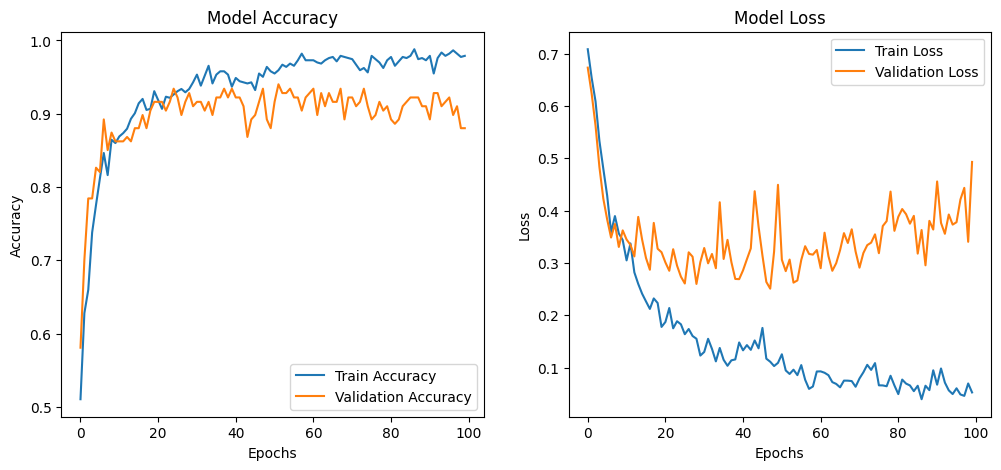

In [10]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')

# Plot loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')

plt.show()

In [16]:
def predict_audio(file_path):
    mfcc_features = extract_mfcc(file_path)
    if mfcc_features is None:
        return "Error processing file"

    mfcc_features = np.expand_dims(mfcc_features, axis=0)  # Add batch dimension
    prediction = model.predict(mfcc_features)

    return "Parkinson’s" if prediction[0][0] > 0.5 else "Healthy"

# Example usage:
file_to_predict = "/content/FB1GLIAUDLO50F100220171308.wav"
print(predict_audio(file_to_predict))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Parkinson’s
